<a href="https://colab.research.google.com/github/Himansh-Shah/Video_classification/blob/main/cricketshotVideoClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install remotezip
!pip install -q git+https://github.com//tensorflow/docs
!pip install einops


  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=40b26f64aff11f06dc1b66800ea4a1e5fa4fcef8a4cd451e9a0b57014ffe4908
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 955.7 kB/s eta 0:00:00


In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections
import os
import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

import einops
import tensorflow as tf
import keras
from keras import layers

In [ ]:
URL = "https://himanshcric.s3.ap-south-1.amazonaws.com/Cover+Drive+-+Made+with+Clipchamp.zip"

In [ ]:
def list_files_from_zip_url(zip_url):
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [ ]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.mp4')]

In [ ]:
files

['Cover Drive - Made with Clipchamp (1).mp4',
 'Cover Drive - Made with Clipchamp (10).mp4',
 'Cover Drive - Made with Clipchamp (11).mp4',
 'Cover Drive - Made with Clipchamp (12).mp4',
 'Cover Drive - Made with Clipchamp (13).mp4',
 'Cover Drive - Made with Clipchamp (14).mp4',
 'Cover Drive - Made with Clipchamp (15).mp4',
 'Cover Drive - Made with Clipchamp (16).mp4',
 'Cover Drive - Made with Clipchamp (17).mp4',
 'Cover Drive - Made with Clipchamp (18).mp4',
 'Cover Drive - Made with Clipchamp (19).mp4',
 'Cover Drive - Made with Clipchamp (2).mp4',
 'Cover Drive - Made with Clipchamp (20).mp4',
 'Cover Drive - Made with Clipchamp (21).mp4',
 'Cover Drive - Made with Clipchamp (22).mp4',
 'Cover Drive - Made with Clipchamp (23).mp4',
 'Cover Drive - Made with Clipchamp (24).mp4',
 'Cover Drive - Made with Clipchamp (25).mp4',
 'Cover Drive - Made with Clipchamp (3).mp4',
 'Cover Drive - Made with Clipchamp (4).mp4',
 'Cover Drive - Made with Clipchamp (5).mp4',
 'Cover Drive - Ma

In [ ]:
def get_class(fname):
  return fname.split('-')[0]

In [ ]:
def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [ ]:
# def select_subset_of_classes(files_for_class, classes, files_per_class):
#   """ Create a dictionary with the class name and a subset of the files in that class.

#     Args:
#       files_for_class: Dictionary of class names (key) and files (values).
#       classes: List of classes.
#       files_per_class: Number of files per class of interest.

#     Returns:
#       Dictionary with class as key and list of specified number of video files in that class.
#   """
#   files_subset = dict()

#   for class_name in classes:
#     class_files = files_for_class[class_name]
#     files_subset[class_name] = class_files[:files_per_class]

#   return files_subset

In [ ]:
def download_from_zip(zip_url, to_dir, file_names):
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir/class_name))
      unzipped_file = to_dir/class_name/fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir/class_name/fn
      unzipped_file.rename(output_file)

In [ ]:
def split_class_list(files_for_class, count):
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls]=files_for_class[cls][count:]
  return split_files, remainder

In [ ]:
def download_subset(zip_url, num_classes, splits, download_dir):
  files=list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)

  files_for_class = get_files_per_class(files)
  classes = list(files_for_class.keys())
  for cls in classes:
    random.shuffle(files_for_class[cls])

  files_for_class =  {x: files_for_class[x] for x in classes}
  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_list(files_for_class, split_count)
    download_from_zip(zip_url, split_dir , split_files)
    dirs[split_name] = split_dir

  return dirs

In [ ]:
download_dir = pathlib.Path('./Cricket_shots/')
paths = download_subset(URL,
                        num_classes = 2,
                        splits = {"train":7, 'val': 3},
                        download_dir = download_dir)

train :


100%|██████████| 14/14 [00:40<00:00,  2.90s/it]


val :


100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


In [ ]:
print(paths)

{'train': PosixPath('Cricket_shots/train'), 'val': PosixPath('Cricket_shots/val')}


In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.mp4')))
video_count_val = len(list(download_dir.glob('val/*/*.mp4')))
video_count_total = video_count_train + video_count_val
video_count_total

20

In [ ]:
import pandas as pd
splits = ["train", "val"]
video_addresses = []
sizes = []
for items in splits:
  for things in list(download_dir.glob(f"{items}/*/*.mp4")):
    # print(f"{things}:{cv2.VideoCapture(things).get(cv2.CAP_PROP_FRAME_COUNT)}")
    video_addresses.append(things)
    src = cv2.VideoCapture(str(things))
    sizes.append(src.get(cv2.CAP_PROP_FRAME_COUNT))

dataframe = pd.DataFrame({"Video_paths": video_addresses,
                         "Frame_size":sizes})
dataframe

,Video_paths,Frame_size
0,Cricket_shots/train/Scoop /Scoop - Made with C...,70.0
1,Cricket_shots/train/Scoop /Scoop - Made with C...,98.0
2,Cricket_shots/train/Scoop /Scoop - Made with C...,60.0
3,Cricket_shots/train/Scoop /Scoop - Made with C...,51.0
4,Cricket_shots/train/Scoop /Scoop - Made with C...,64.0
5,Cricket_shots/train/Scoop /Scoop - Made with C...,90.0
6,Cricket_shots/train/Scoop /Scoop - Made with C...,66.0
7,Cricket_shots/train/Cover Drive /Cover Drive -...,72.0
8,Cricket_shots/train/Cover Drive /Cover Drive -...,56.0
9,Cricket_shots/train/Cover Drive /Cover Drive -...,56.0


In [ ]:
!find ./Cricket_shots

./Cricket_shots
./Cricket_shots/val
./Cricket_shots/val/Scoop 
./Cricket_shots/val/Scoop /Scoop - Made with Clipchamp (7).mp4
./Cricket_shots/val/Scoop /Scoop - Made with Clipchamp (4).mp4
./Cricket_shots/val/Scoop /Scoop - Made with Clipchamp (3).mp4
./Cricket_shots/val/Cover Drive 
./Cricket_shots/val/Cover Drive /Cover Drive - Made with Clipchamp (7).mp4
./Cricket_shots/val/Cover Drive /Cover Drive - Made with Clipchamp (9).mp4
./Cricket_shots/val/Cover Drive /Cover Drive - Made with Clipchamp.mp4
./Cricket_shots/train
./Cricket_shots/train/Scoop 
./Cricket_shots/train/Scoop /Scoop - Made with Clipchamp (8).mp4
./Cricket_shots/train/Scoop /Scoop - Made with Clipchamp (2).mp4
./Cricket_shots/train/Scoop /Scoop - Made with Clipchamp.mp4
./Cricket_shots/train/Scoop /Scoop - Made with Clipchamp (1).mp4
./Cricket_shots/train/Scoop /Scoop - Made with Clipchamp (9).mp4
./Cricket_shots/train/Scoop /Scoop - Made with Clipchamp (5).mp4
./Cricket_shots/train/Scoop /Scoop - Made with Clipchamp 

##Converting videos into frame and tensors

In [ ]:
def format_frames(frame, output_size):
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 6):
  result = []
  src = cv2.VideoCapture(str(video_path))
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1)* frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start +1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames-1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2,1,0]]

  return result

In [ ]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  24.2M      0  0:00:02  0:00:02 --:--:-- 24.2M


In [ ]:
video_path = "End_of_a_jam.ogv"

In [ ]:
sample_video = frames_from_video_file(video_path, n_frames=10)
sample_video.shape

(10, 224, 224, 3)

In [ ]:
def to_gif(images):
  converted_images = np.clip(images*255,0,255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


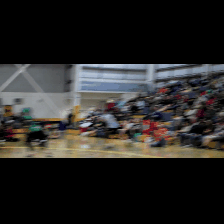

In [ ]:
to_gif(sample_video)

In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training=False):
    self.path = path
    self.n_frames = n_frames
    self.training = training
    # self.frame_steps = frame_steps
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()
    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name]
      yield video_frames, label

In [ ]:
fg = FrameGenerator(paths['train'], n_frames=10 , training= True)
frames, label = next(fg())

print(f"shape: {frames.shape}")
print(f"Label: {label}")

shape: (10, 224, 224, 3)
Label: 1


In [ ]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype= tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(paths['train'], 10, training=True),
                                          output_signature = output_signature)

In [ ]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)


In [ ]:
val_ds = tf.data.Dataset.from_generator(FrameGenerator(paths['val'], 10),
                                        output_signature = output_signature)

In [ ]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f"Shape validation set of frames: {val_frames.shape}")
print(f"Shape validation labels: {val_labels.shape}")


Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape validation set of frames: (10, 224, 224, 3)
Shape validation labels: ()


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)

In [ ]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)
train_frames, train_labels = next(iter(train_ds))
print(f"Shape of training set of frames: {train_frames.shape}")
print(f"Shape of training labels: {train_labels.shape}")

val_frames, val_labels = next(iter(val_ds))
print(f"Shape of validation set of frames: {val_frames.shape}")
print(f"Shape of validaiton labels: {val_labels.shape}")

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validaiton labels: (2,)


In [ ]:
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.fit(train_ds,
          epochs=10,
          callbacks = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'))

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
      7/Unknown - 26s 2s/step - loss: 1.7495 - accuracy: 0.5000

7/7 [==============================] - 27s 2s/step - loss: 1.7495 - accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.8692 - accuracy: 0.5714

7/7 [==============================] - 11s 2s/step - loss: 0.8692 - accuracy: 0.5714
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.8571

7/7 [==============================] - 11s 2s/step - loss: 0.5207 - accuracy: 0.8571
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8571

7/7 [==============================] - 11s 2s/step - loss: 0.4255 - accuracy: 0.8571
Epoch 5/10
7/7 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.9286

7/7 [==============================] - 11s 2s/step - loss: 0.3591 - accuracy: 0.9286
Epoch 6/10
7/7 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.9286

7/7 [==============================] - 11s 1s/step - loss: 0.2921 - accuracy: 0.9286
Epoch 7/10
7/7 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9286

7/7 [==============================] - 11s 2s/step - loss: 0.2486 - accuracy: 0.9286
Epoch 8/10
7/7 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9286

7/7 [==============================] - 11s 2s/step - loss: 0.2068 - accuracy: 0.9286
Epoch 9/10
7/7 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 1.0000

7/7 [==============================] - 10s 1s/step - loss: 0.1808 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 1.0000

7/7 [==============================] - 11s 2s/step - loss: 0.1622 - accuracy: 1.0000


In [ ]:
model.evaluate(val_frames, val_labels)

1/1 [==============================] - 6s 6s/step - loss: 0.1463 - accuracy: 1.0000


[0.14627549052238464, 1.0]

In [ ]:
model.predict(val_frames)

1/1 [==============================] - 5s 5s/step


array([[ 3.1534827,  0.934697 , -5.5307794, -4.8456836, -4.306784 ,
        -5.327607 , -4.395473 , -4.396471 , -5.619409 , -3.9482365],
       [ 2.6184216,  0.9878176, -4.586867 , -4.669558 , -4.0020733,
        -4.756751 , -3.9770968, -3.8912807, -5.043991 , -3.4542742]],
      dtype=float32)

In [ ]:
val_labels

<tf.Tensor: shape=(2,), dtype=int16, numpy=array([0, 0], dtype=int16)>

In [ ]:
HEIGHT = 224
WIDTH= 224


In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1],kernel_size[2]),
                      padding= padding),
        layers.Conv3D(filters = filters,
                     kernel_size=(kernel_size[0], 1, 1),
                     padding=padding)
    ])

    def call(self, x):
      return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same"),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size = kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

    def call(self, x):
      return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

    def call(self, x):
      return self.seq(x)

In [ ]:
def add_residual_block(input, filters, kernel_size):
  out = ResidualMain(filters, kernel_size)(input)
  res = input
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
      images, '(b t) h w c -> b t h w c',
      t = old_shape['t']
    )
    return videos


In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size = (3,7,7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT//2 , WIDTH//2)(x)

x = add_residual_block(x, 16, (3,3,3))
x = ResizeVideo(HEIGHT//4, WIDTH//4)(x)

x = add_residual_block(x, 32, (3,3,3))
x = ResizeVideo(HEIGHT//8, WIDTH//8)(x)

x = add_residual_block(x, 64, (3,3,3))
x = ResizeVideo(HEIGHT//16, WIDTH//16)(x)


x = add_residual_block(x, 128, (3,3,3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

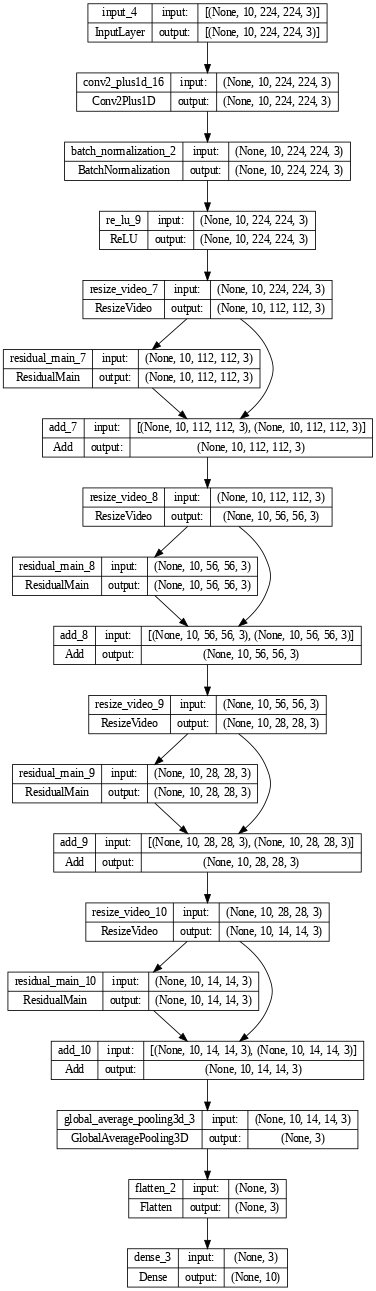

In [ ]:
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)